In [1]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
    classification_report,
    auc,
)

import pickle

In [2]:
# path to store trained model
model_path = "01_dane/04_models"
# name of model pickle file
model_name = "lgb_new.pkl"

# path to input dataset
data_path = "01_dane/03_modeling_data"
data_name = "base_new.csv"

# Load data

In [3]:
df = pd.read_csv(f"{data_path}/{data_name}")
# use modified status column
df["STATUS"] = df["NEW_STATUS"]
# drop not needed columns
df = df.drop(columns=["dataset", "NEW_STATUS"])

## split sample

In [4]:
y_col = "STATUS"

X = df.drop(columns=y_col)
y = df[y_col]
# Split data into training(80%) and testing(20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model

In [5]:
# create a grid of hyperparameters
param_grid = {
    "num_leaves": [3, 5, 10, 16, 20],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 150, 175, 200],
    "colsample_bytree": [0.4, 0.8],
}

In [6]:
model = lgb.LGBMClassifier(objective="binary", verbosity=0)

# Use cross-valiation for finding hyperparams
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=3,
)

In [7]:
# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=3;, score=0.914 total time=   0.1s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=3;, score=0.917 total time=   0.1s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=3;, score=0.919 total time=   0.1s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=5;, score=0.925 total time=   0.1s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=5;, score=0.929 total time=   0.1s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=5;, score=0.932 total time=   0.1s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=10;, score=0.931 total time=   0.2s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.05, n_estimators=100, num_leaves=10;, score=0.934 tot

In [8]:
best_params

{'colsample_bytree': 0.4,
 'learning_rate': 0.05,
 'n_estimators': 200,
 'num_leaves': 16}

In [9]:
# fit model using best paramenters
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,16
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# Test model

### Basic scores

In [10]:
# predict on test set
pred = best_model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3879
           1       0.93      0.74      0.83      1008

    accuracy                           0.94      4887
   macro avg       0.93      0.86      0.89      4887
weighted avg       0.94      0.94      0.93      4887



### Confuction matrix

In [11]:
def plot_confuction_matrix(model, X: pd.DataFrame, y: pd.DataFrame):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    return cm_display

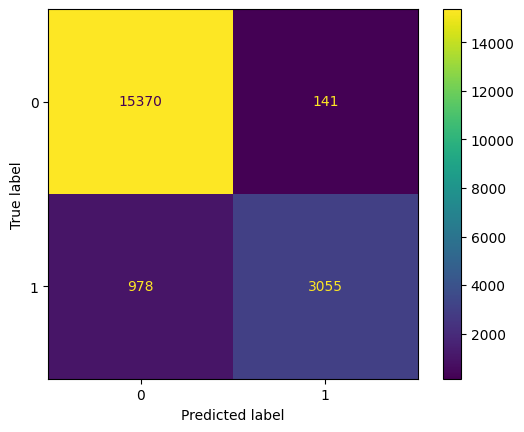

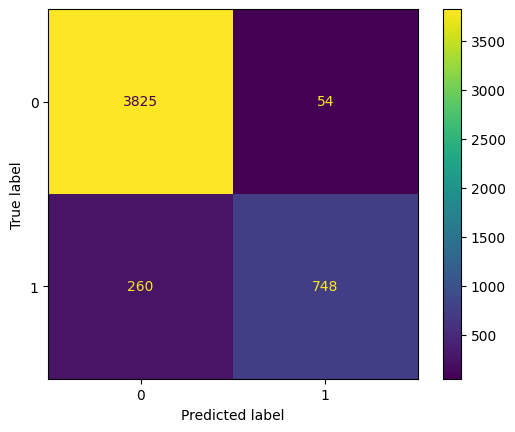

In [12]:
plot_confuction_matrix(best_model, X_train, y_train)
plot_confuction_matrix(best_model, X_test, y_test)

### ROC curve

In [13]:
def plot_roc(model, X: pd.DataFrame, y: pd.DataFrame):
    # predict_proba returns probability for both 0 and 1,
    # for this reason we need to pick only one column with probs for STATUS=1
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    print(f"AUC = {round(roc_auc, 4)}")

AUC = 0.9638
AUC = 0.9455


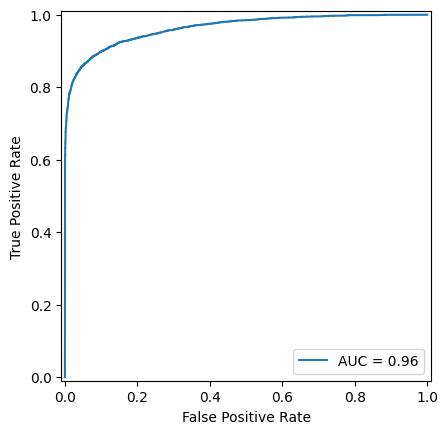

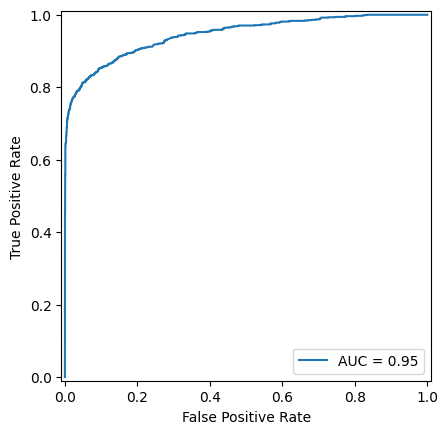

In [14]:
# on train dataset
plot_roc(best_model, X_train, y_train)
plot_roc(best_model, X_test, y_test)

# Save model

In [15]:
# save model to pickle
with open(f"{model_path}/{model_name}", "wb") as fout:
    pickle.dump(best_model, fout)
